In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm


# Определение устройства (GPU или CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Загрузка и подготовка данных
def load_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size,
                             shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size,
                            shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, classes

# Определение модели CNN
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()

        # Первый сверточный блок
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2) )

        # Второй сверточный блок
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3))

        # Третий сверточный блок
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4))

        # Полносвязные слои
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

# Обучение модели
def train_model(model, trainloader, criterion, optimizer, epochs=50):
    model.train()
    train_loss, train_acc = [], []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = correct / total

        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        print(f'Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%')

    return train_loss, train_acc

# Оценка модели
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy

# Сохранение модели
def save_model(model, path='cifar10_cnn.pth'):
    torch.save(model.state_dict(), path)
    print(f'Model saved to {path}')

# Визуализация обучения
def plot_history(train_loss, train_acc):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [4]:
# Основной процесс
def main(epochs = 5):
    # Загрузка данных
    trainloader, testloader, classes = load_data()

    # Инициализация модели
    model = CIFAR10CNN().to(device)
    print(model)

    # Критерий и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Обучение модели
    train_loss, train_acc = train_model(model, trainloader, criterion, optimizer, epochs = epochs)

    # Оценка модели
    test_acc = evaluate_model(model, testloader)

    # Сохранение модели
    save_model(model)

    # Визуализация
    plot_history(train_loss, train_acc)


CIFAR10CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dro

Epoch 1/30: 100%|██████████| 782/782 [00:14<00:00, 52.43it/s]


Epoch 1 | Loss: 1.3678 | Accuracy: 0.51%


Epoch 2/30: 100%|██████████| 782/782 [00:15<00:00, 52.07it/s]


Epoch 2 | Loss: 0.9643 | Accuracy: 0.66%


Epoch 3/30: 100%|██████████| 782/782 [00:16<00:00, 47.44it/s]


Epoch 3 | Loss: 0.8315 | Accuracy: 0.71%


Epoch 4/30: 100%|██████████| 782/782 [00:15<00:00, 52.13it/s]


Epoch 4 | Loss: 0.7465 | Accuracy: 0.74%


Epoch 5/30: 100%|██████████| 782/782 [00:14<00:00, 52.29it/s]


Epoch 5 | Loss: 0.6904 | Accuracy: 0.76%


Epoch 6/30: 100%|██████████| 782/782 [00:15<00:00, 50.23it/s]


Epoch 6 | Loss: 0.6446 | Accuracy: 0.78%


Epoch 7/30: 100%|██████████| 782/782 [00:15<00:00, 51.30it/s]


Epoch 7 | Loss: 0.6018 | Accuracy: 0.79%


Epoch 8/30: 100%|██████████| 782/782 [00:15<00:00, 48.88it/s]


Epoch 8 | Loss: 0.5664 | Accuracy: 0.81%


Epoch 9/30: 100%|██████████| 782/782 [00:15<00:00, 49.93it/s]


Epoch 9 | Loss: 0.5394 | Accuracy: 0.82%


Epoch 10/30: 100%|██████████| 782/782 [00:15<00:00, 49.71it/s]


Epoch 10 | Loss: 0.5148 | Accuracy: 0.82%


Epoch 11/30: 100%|██████████| 782/782 [00:15<00:00, 49.67it/s]


Epoch 11 | Loss: 0.4987 | Accuracy: 0.83%


Epoch 12/30: 100%|██████████| 782/782 [00:16<00:00, 46.33it/s]


Epoch 12 | Loss: 0.4783 | Accuracy: 0.84%


Epoch 13/30: 100%|██████████| 782/782 [00:15<00:00, 50.83it/s]


Epoch 13 | Loss: 0.4605 | Accuracy: 0.84%


Epoch 14/30: 100%|██████████| 782/782 [00:15<00:00, 50.91it/s]


Epoch 14 | Loss: 0.4408 | Accuracy: 0.85%


Epoch 15/30: 100%|██████████| 782/782 [00:15<00:00, 51.18it/s]


Epoch 15 | Loss: 0.4236 | Accuracy: 0.85%


Epoch 16/30: 100%|██████████| 782/782 [00:16<00:00, 48.49it/s]


Epoch 16 | Loss: 0.4132 | Accuracy: 0.86%


Epoch 17/30: 100%|██████████| 782/782 [00:15<00:00, 51.79it/s]


Epoch 17 | Loss: 0.3979 | Accuracy: 0.86%


Epoch 18/30: 100%|██████████| 782/782 [00:15<00:00, 51.03it/s]


Epoch 18 | Loss: 0.3864 | Accuracy: 0.87%


Epoch 19/30: 100%|██████████| 782/782 [00:15<00:00, 51.29it/s]


Epoch 19 | Loss: 0.3752 | Accuracy: 0.87%


Epoch 20/30: 100%|██████████| 782/782 [00:15<00:00, 51.13it/s]


Epoch 20 | Loss: 0.3683 | Accuracy: 0.87%


Epoch 21/30: 100%|██████████| 782/782 [00:16<00:00, 48.71it/s]


Epoch 21 | Loss: 0.3582 | Accuracy: 0.88%


Epoch 22/30: 100%|██████████| 782/782 [00:15<00:00, 50.89it/s]


Epoch 22 | Loss: 0.3531 | Accuracy: 0.88%


Epoch 23/30: 100%|██████████| 782/782 [00:15<00:00, 50.70it/s]


Epoch 23 | Loss: 0.3409 | Accuracy: 0.88%


Epoch 24/30: 100%|██████████| 782/782 [00:15<00:00, 51.03it/s]


Epoch 24 | Loss: 0.3357 | Accuracy: 0.88%


Epoch 25/30: 100%|██████████| 782/782 [00:16<00:00, 48.00it/s]


Epoch 25 | Loss: 0.3251 | Accuracy: 0.89%


Epoch 26/30: 100%|██████████| 782/782 [00:15<00:00, 51.98it/s]


Epoch 26 | Loss: 0.3213 | Accuracy: 0.89%


Epoch 27/30: 100%|██████████| 782/782 [00:15<00:00, 50.89it/s]


Epoch 27 | Loss: 0.3185 | Accuracy: 0.89%


Epoch 28/30: 100%|██████████| 782/782 [00:15<00:00, 51.17it/s]


Epoch 28 | Loss: 0.3149 | Accuracy: 0.89%


Epoch 29/30: 100%|██████████| 782/782 [00:15<00:00, 49.19it/s]


Epoch 29 | Loss: 0.3034 | Accuracy: 0.89%


Epoch 30/30: 100%|██████████| 782/782 [00:16<00:00, 48.45it/s]

Epoch 30 | Loss: 0.2996 | Accuracy: 0.90%


Accuracy on test set: 87.26%
Model saved to cifar10_cnn.pth


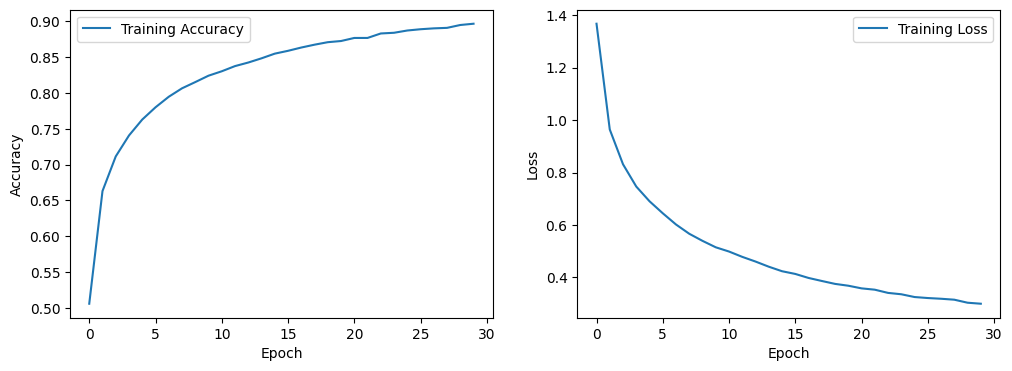

In [5]:
main(30)